# Tópicos de Minería de datos - TP 4
## Autora: Aldana Zarate

Feedback:
En el 1 y 2 los comentarios no van para lo que estamos mirando, cómo depende el funcionamiento del método de algún factor como la complejidad del weak learner.

En 3 y 4, faltó hacer un bucle más, hay que hacer uno para elegir los parámetros y otro para medir el error en test. 

# Imports

In [ ]:
install.packages("adabag")
library("adabag")
install.packages("randomForest")
library("randomForest")
library("e1071")
library("caret")

# Ejercicio 1


In [26]:
load("TP4.Rdata", verbose=T)

Loading objects:
  esp_train
  RRL
  esp_test
  diag_test
  .Random.seed
  diag_train


## Espirales con ruido

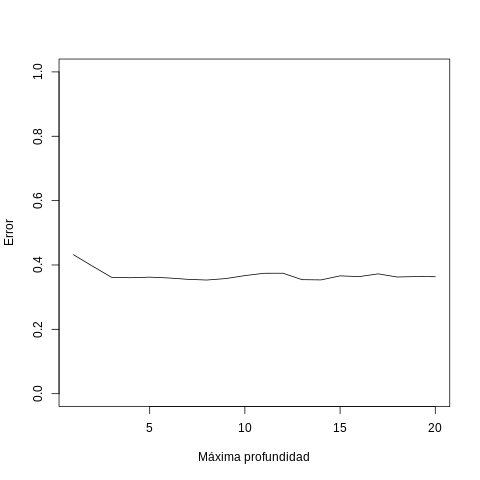

In [ ]:
espirales.errores <- double(20)

for(depth in 1:20){
  espirales.adaboost <- boosting(class ~ ., data = esp_train, mfinal = 200, coef="Freund",
                                control = rpart.control(maxdepth = depth))
  pred <- predict(espirales.adaboost, esp_test)
  espirales.errores[depth] <- pred$error
}

plot(c(1:20), espirales.errores, type="l", xlab="Máxima profundidad", ylab="Error", ylim=c(0,1))

Podemos observar un error muy alto a lo largo de todas las ejecuciones, sin importar la profundidad. Estos errores de alrededor del 40% parecen manifestar una sensibilidad alta al ruido.

## Diagonal

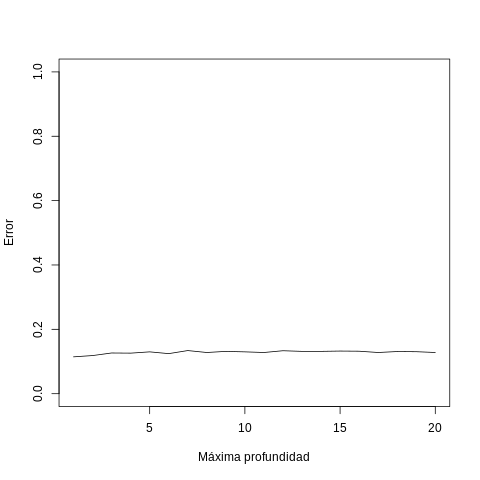

In [ ]:
diagonal.errores <- double(20)

for(depth in 1:20){
  diagonal.adaboost <- boosting(class ~ ., data = diag_train, mfinal = 200, coef="Freund",
                                control = rpart.control(maxdepth = depth))
  pred <- predict(diagonal.adaboost, diag_test)
  diagonal.errores[depth] <- pred$error
}

plot(c(1:20), diagonal.errores, type="l", xlab="Máxima profundidad", ylab="Error", ylim=c(0,1))

Para el caso del problema diagonal se obtienen mejores resultados, con errores alrededor del 10-15% para todas las profundidades. Esto puede deber a que las clases se encuentran mucho más separadas que en el dataset anterior; pero siguen existiendo superposiciones, dado lugar a errores mejores pero tampoco ideales.

# Ejercicio 2

In [ ]:
# visualizamos el dataset
nvars <- dim(RRL)[2]
head(RRL)

  Amplitude AndersonDarling Autocor_length Beyond1Std   CAR_mean     CAR_sigma
1   0.12125       0.6320207              1  0.2835821   26.96911 -2.053218e-08
2   0.11900       0.6567491              1  0.2794118   27.34302  3.789182e-09
3   0.28200       1.0000000              1  0.2318841 3817.29126 -4.223939e+00
4   0.04375       0.9999802              1  0.1818182   23.08996 -2.235318e-02
5   0.33000       0.4083999              1  0.2954545   27.73315  3.789182e-09
6   0.23450       0.4528910              1  0.3288591   27.32995  4.427833e-09
      CAR_tau Con       Eta_e FluxPercentileRatioMid20 FluxPercentileRatioMid35
1 0.594827064   0   1363382.6               0.21739130                0.3043478
2 0.594920127   0   1134045.3               0.10576923                0.2692308
3 0.003960514   0   2425723.6               0.05839416                0.1113139
4 0.595819184   0    677993.1               0.21311475                0.2950820
5 0.594920127   0 824000203.6               0.1

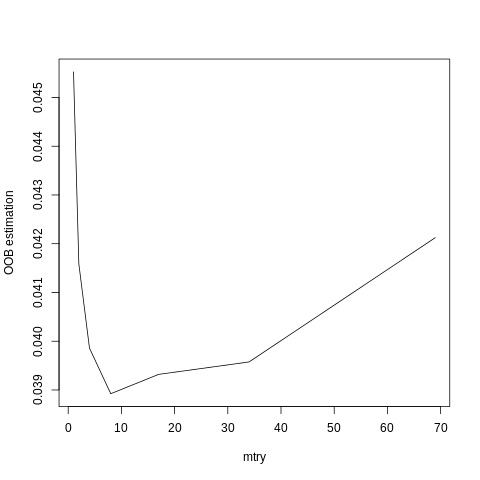

In [ ]:
mtrys <- c(69, 34, 17, 8, 4, 2, 1)
cant.mtrys <- length(mtrys)

oob.estimations <- double(cant.mtrys)
for(mtry in 1:cant.mtrys){
  errores.mtry <- double(5)
  for(run in 1:5){
    rf.model <- randomForest(RRL[,-70], RRL[,70], mtry=mtrys[mtry], ntree=1000)
    oob.est <- rf.model$err.rate[1000]
    errores.mtry[run] <- oob.est
  }
  oob.estimations[mtry] <- mean(errores.mtry)
}

plot(mtrys, oob.estimations, type="l", xlab="mtry", ylab="OOB estimation")

En la gráfica se puede observar que independientemente del número de variables que se tomen, se obtienen muy buenos resultados (sobretodo que es la estimación OOB). Hay solo un 1% de diferencia cuando el error comienza a decrecer a partir de las 8 variables aproximadamente.

# Ejercicio 3

In [ ]:
load("lampone.Rdata")
lampone.x <- lampone[, -c(1,143,144)] # saco las clases y la 144 porque me da error de que no es numerico sino
lampone.nvars = dim(lampone.x)[2]
# el valor optimo podría andar alrededor de sqrt(lampone.nvars), es decir, 12
mtrys <- 0:floor(log(lampone.nvars, 2))
mtrys <- floor(lampone.nvars / (2 ^ mtrys))

## Random forest

mtry óptima:  17 Error de la mtry:  0.07755102

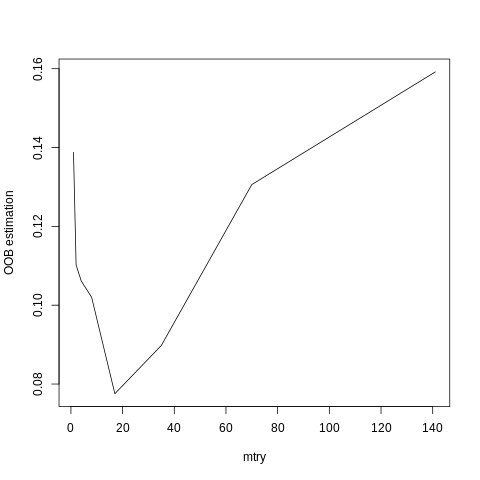

In [ ]:
mtrys <- 0:floor(log(lampone.nvars, 2))
mtrys <- floor(lampone.nvars / (2 ^ mtrys))
cant.mtrys <- length(mtrys)

oob.estimations <- double(cant.mtrys)
for(mtry in 1:cant.mtrys){
  errores.mtry <- double(5)
  for(run in 1:5){
    rf.model <- randomForest(lampone.x, lampone[,143], mtry=mtrys[mtry], ntree=1000)
    oob.est <- rf.model$err.rate[1000]
    errores.mtry[run] <- oob.est
  }
  oob.estimations[mtry] <- mean(errores.mtry)
}

cat("mtry óptima: ", mtrys[which.min(oob.estimations)], "Error de la mtry: ", oob.estimations[which.min(oob.estimations)])
plot(mtrys, oob.estimations, type="l", xlab="mtry", ylab="OOB estimation")


## Boosting

Como tenemos muy pocas muestras vamos a usar k-fold cross validation con 5 folds, 4 para train y 1 para test (proporción 80/20)

In [ ]:
# Esta versión que optimiza la profundidad máxima queda comentada porque al ser
# muy desbalanceada la relación entre cantidad de variables y cantidad de muestras,
# la ejecución se corta en el minuto 7 con el error:
# Error in cbind(yval2, yprob, nodeprob) : number of rows of matrices must match (see arg 2)
# fuentes: https://kleinfelter.com/learning-r-painful-r-learnings

# lampone.cv <- lampone[,-c(1,144)] # sacamos las columnas que no sirven
# # KFold Cross Validation (autorobado de IIA)
# totalKFolds = 5
# kFoldsTrain = 1:5
# indexData <- createFolds(lampone.cv[, 142], k = totalKFolds)  # ahora la clase es la 142

# lampone.errores.depth <- double(20)

# for(depth in 1:20){
#   lampone.errores <- c()
#   for (kfold in kFoldsTrain) {
#     # Partimos los conjuntos en entrenamiento y test
#     lamponeTest <- lampone.cv[indexData[[kfold]], ]
#     lamponeTrain <- lampone.cv[-indexData[[kfold]], ]

#     lampone.adaboost <- boosting(N_tipo ~ ., data = lamponeTrain, mfinal = 200, coef="Freund",
#                                 control = rpart.control(maxdepth = depth))
#     pred <- predict(lampone.adaboost, lamponeTest)
#     lampone.errores <- c(lampone.errores, pred$error)
#   }
#   lampone.errores.depth[depth] <- mean(lampone.errores)
# }

# cat("Profundidad óptima: ", which.min(lampone.errores.depth), "Error de la prof: ", lampone.errores.depth[which.min(lampone.errores.depth)])
# plot(c(1:20), lampone.errores.depth, type="l", xlab="Máxima profundidad", ylab="Error", ylim=c(0,1))

  number of rows of matrices must match (see arg 2)




Error in cbind(yval2, yprob, nodeprob) : 
  number of rows of matrices must match (see arg 2)


Procedemos a ejecutar el método pero sin iterar sobre las posibles profundidades:

In [16]:
lampone.cv <- lampone[,-c(1,144)] # sacamos las columnas que no sirven
# KFold Cross Validation (autorobado de IIA)
totalKFolds = 5
kFoldsTrain = 1:5
indexData <- createFolds(lampone.cv[, 142], k = totalKFolds)  # ahora la clase es la 142

lampone.errores <- c()
for (kfold in kFoldsTrain) {
  # Partimos los conjuntos en entrenamiento y test
  lamponeTest <- lampone.cv[indexData[[kfold]], ]
  lamponeTrain <- lampone.cv[-indexData[[kfold]], ]

  lampone.adaboost <- boosting(N_tipo ~ ., data = lamponeTrain, mfinal = 200, coef="Freund",
                              control = rpart.control(maxdepth = 17))
  pred <- predict(lampone.adaboost, lamponeTest)
  lampone.errores <- c(lampone.errores, pred$error)
}
lampone.error <- mean(lampone.errores)

cat("Error en boosting: ", lampone.error)

Error en boosting:  0.08

## SVM kernel RBF

In [20]:
# hay que optimizar el gamma y el costo

lampone.cv <- lampone[,-c(1,144)] # sacamos las columnas que no sirven
# KFold Cross Validation (autorobado de IIA)
totalKFolds = 5
kFoldsTrain = 1:5
indexData <- createFolds(lampone.cv[, 142], k = totalKFolds)  # ahora la clase es la 142

lampone.errores.overall <- matrix(, nrow = 0, ncol = 3)
colnames(lampone.errores.overall) <- c("c","g","Error")

for(c in c(10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10,10^2,10^3,10^4,10^5)){
  for(g in c(10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10,10^2,10^3)){
    lampone.errores <- c()
    for (kfold in kFoldsTrain) {
      # Partimos los conjuntos en entrenamiento y test
      lamponeTest <- lampone.cv[indexData[[kfold]], ]
      lamponeTrain <- lampone.cv[-indexData[[kfold]], ]

      lampone.svm.rbf <- svm(N_tipo~., lamponeTrain, kernel="radial", gamma=g, cost=c)
      pred<-predict(lampone.svm.rbf, newdata = lamponeTest)
      error<-1-sum(pred==lamponeTest[,"N_tipo"])/dim(lamponeTest)[1]
      lampone.errores <- c(lampone.errores, error)
    }
    lampone.errores.overall <- rbind(lampone.errores.overall, c(c, g, mean(lampone.errores)))
  }
}

In [21]:
df <- as.data.frame(lampone.errores.overall)
opt <- df[which.min(df$Error),]
cat("Parámetros óptimos: \n c:", as.numeric(opt[1]), " g: ", as.numeric(opt[2]), " Error: ", as.numeric(opt[3]))

Parámetros óptimos: 
 c: 100  g:  1e-05  Error:  0.1812121

## SVM Polinomial

In [22]:
# hay que optimizar el grado del polinomio y el costo

lampone.cv <- lampone[,-c(1,144)] # sacamos las columnas que no sirven
# KFold Cross Validation (autorobado de IIA)
totalKFolds = 5
kFoldsTrain = 1:5
indexData <- createFolds(lampone.cv[, 142], k = totalKFolds)  # ahora la clase es la 142

lampone.errores.overall <- matrix(, nrow = 0, ncol = 3)
colnames(lampone.errores.overall) <- c("c","d","Error")

for(c in c(10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10,10^2,10^3,10^4,10^5)){
  for(d in 1:5){
    lampone.errores <- c()
    for (kfold in kFoldsTrain) {
      # Partimos los conjuntos en entrenamiento y test
      lamponeTest <- lampone.cv[indexData[[kfold]], ]
      lamponeTrain <- lampone.cv[-indexData[[kfold]], ]

      lampone.svm.pol <- svm(N_tipo~., lamponeTrain, kernel="polynomial", degree=d, cost=c)
      pred<-predict(lampone.svm.pol, newdata = lamponeTest)
      error<-1-sum(pred==lamponeTest[,"N_tipo"])/dim(lamponeTest)[1]
      lampone.errores <- c(lampone.errores, error)
    }
    lampone.errores.overall <- rbind(lampone.errores.overall, c(c, d, mean(lampone.errores)))
  }
}

In [23]:
df <- as.data.frame(lampone.errores.overall)
opt <- df[which.min(df$Error),]
cat("Parámetros óptimos: \n c:", as.numeric(opt[1]), " d: ", as.numeric(opt[2]), " Error: ", as.numeric(opt[3]))

Parámetros óptimos: 
 c: 100  d:  1  Error:  0.06

## Comparación de resultados

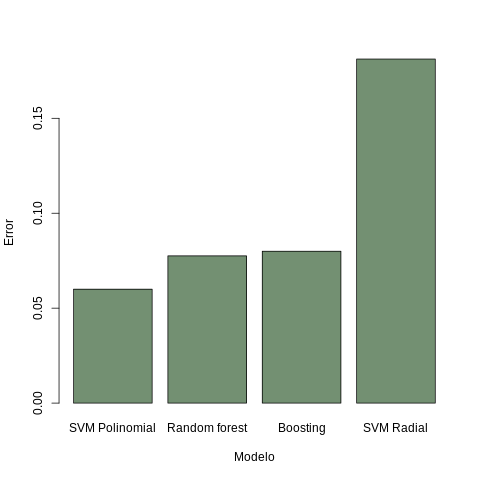

In [35]:
results <- data.frame("Modelo"=c("SVM Polinomial", "Random forest", "Boosting", "SVM Radial"),
                      "Error"=c(0.06, 0.07755102, 0.08, 0.1812121))

barplot(height=results$Error, names.arg=results$Modelo, xlab="Modelo", ylab="Error", col = "#739072")

Conclusiones:
- El método con mejor performance fue el SVM polinomial con un error muy aceptable del 5%
- Le siguen RF y Boosting ambos con errores muy similares alrededor del 8%
- Por último quedó SVM Radial, con un error del 18%. No es muy bueno.
- El método de RF eligió 17 como mtry óptima, dandole validez a la regla de la raíz cuadrada (que era 12, está muy cerca)

# Ejercicio 4

In [28]:
%%R
nrow(RRL)

[1] 7060


En este caso tenemos una muestra más amplia así que no es necesario hacer cross validation.

In [30]:
%%R
RRL.x <- RRL[, -70]
RRL.nvars = dim(RRL.x)[2]
# el valor optimo podría andar alrededor de sqrt(RRL.nvars), es decir, 8-9
mtrys <- 0:floor(log(RRL.nvars, 2))
mtrys <- floor(RRL.nvars / (2 ^ mtrys))

## Random forest

mtry óptima:  17 Error de la mtry:  0.03886686

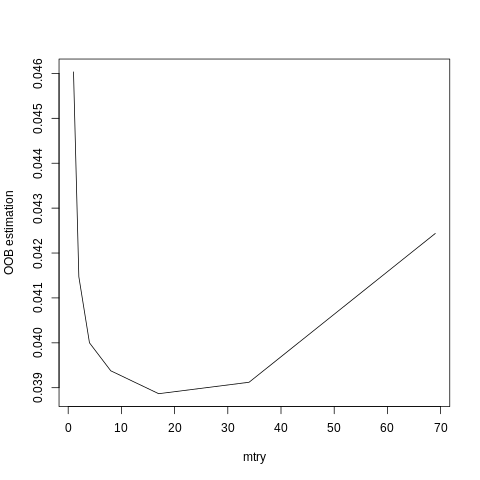

In [31]:
%%R
mtrys <- 0:floor(log(RRL.nvars, 2))
mtrys <- floor(RRL.nvars / (2 ^ mtrys))
cant.mtrys <- length(mtrys)

oob.estimations <- double(cant.mtrys)
for(mtry in 1:cant.mtrys){
  errores.mtry <- double(5)
  for(run in 1:5){
    rf.model <- randomForest(RRL.x, RRL[,70], mtry=mtrys[mtry], ntree=1000)
    oob.est <- rf.model$err.rate[1000]
    errores.mtry[run] <- oob.est
  }
  oob.estimations[mtry] <- mean(errores.mtry)
}

cat("mtry óptima: ", mtrys[which.min(oob.estimations)], "Error de la mtry: ", oob.estimations[which.min(oob.estimations)])
plot(mtrys, oob.estimations, type="l", xlab="mtry", ylab="OOB estimation")

## Boosting


In [32]:
%%R
# hago proporcion 80/20 entre train y test
smp.size <- floor(0.8 * nrow(RRL))
train_r <- sample(seq_len(nrow(RRL)), size = smp.size)

rrl.train <- RRL[train_r, ]
rrl.test <- RRL[-train_r, ]

In [33]:
%%R
rrl.errores <- double(20)

for(depth in 1:20){
  rrl.adaboost <- boosting(Tipo ~ ., data = rrl.train, mfinal = 200, coef="Freund",
                                control = rpart.control(maxdepth = depth))
  pred <- predict(rrl.adaboost, rrl.test)
  rrl.errores[depth] <- pred$error
}



Profundidad máxima:  9 Error:  0.03328612

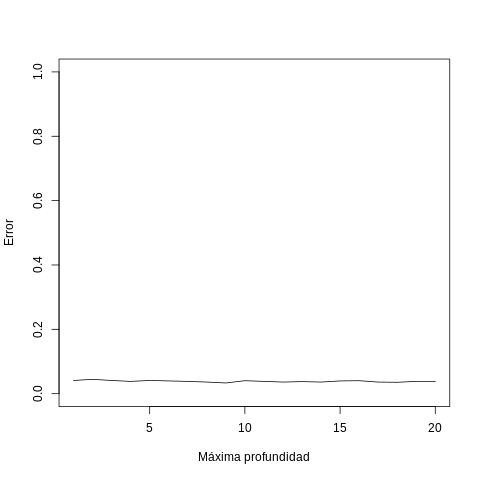

In [34]:
%%R
cat("Profundidad máxima: ", which.min(rrl.errores), "Error: ", min(rrl.errores))
plot(c(1:20), rrl.errores, type="l", xlab="Máxima profundidad", ylab="Error", ylim=c(0,1))

## SVM Radial

In [36]:
%%R
# hago proporcion 80/20 entre train y test
smp.size <- floor(0.8 * nrow(RRL))
train_r <- sample(seq_len(nrow(RRL)), size = smp.size)

rrl.train <- RRL[train_r, ]
rrl.test <- RRL[-train_r, ]

In [37]:
%%R
rrl.errores.overall <- matrix(, nrow = 0, ncol = 3)
colnames(rrl.errores.overall) <- c("c","g","Error")

for(c in c(10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10,10^2,10^3,10^4,10^5)){
  for(g in c(10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10,10^2,10^3)){
    rrl.svm.rbf <- svm(Tipo~., rrl.train, kernel="radial", gamma=g, cost=c)
    pred<-predict(rrl.svm.rbf, newdata = rrl.test)
    error<-1-sum(pred==rrl.test[,"Tipo"])/dim(rrl.test)[1]
    rrl.errores.overall <- rbind(rrl.errores.overall, c(c, g, error))
  }
}

In [38]:
%%R
df <- as.data.frame(rrl.errores.overall)
opt <- df[which.min(df$Error),]
cat("Parámetros óptimos: \n c:", as.numeric(opt[1]), " g: ", as.numeric(opt[2]), " Error: ", as.numeric(opt[3]))

Parámetros óptimos: 
 c: 1e+05  g:  1e-04  Error:  0.0694051

## SVM Polinomial

In [42]:
%%R
# hago proporcion 80/20 entre train y test
smp.size <- floor(0.8 * nrow(RRL))
train_r <- sample(seq_len(nrow(RRL)), size = smp.size)

rrl.train <- RRL[train_r, ]
rrl.test <- RRL[-train_r, ]

In [43]:
%%R
rrl.errores.overall <- matrix(, nrow = 0, ncol = 3)
colnames(rrl.errores.overall) <- c("c","d","Error")

for(c in c(10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10,10^2,10^3,10^4,10^5)){
  for(d in 1:5){
    rrl.svm.pol <- svm(Tipo~., rrl.train, kernel="polynomial", degree=d, cost=c)
    pred<-predict(rrl.svm.pol, newdata = rrl.test)
    error<-1-sum(pred==rrl.test[,"Tipo"])/dim(rrl.test)[1]
    rrl.errores.overall <- rbind(rrl.errores.overall, c(c, d, error))
  }
}

In [44]:
%%R
df <- as.data.frame(rrl.errores.overall)
opt <- df[which.min(df$Error),]
cat("Parámetros óptimos: \n c:", as.numeric(opt[1]), " d: ", as.numeric(opt[2]), " Error: ", as.numeric(opt[3]))

Parámetros óptimos: 
 c: 1000  d:  1  Error:  0.08002833

## Comparación de resultados

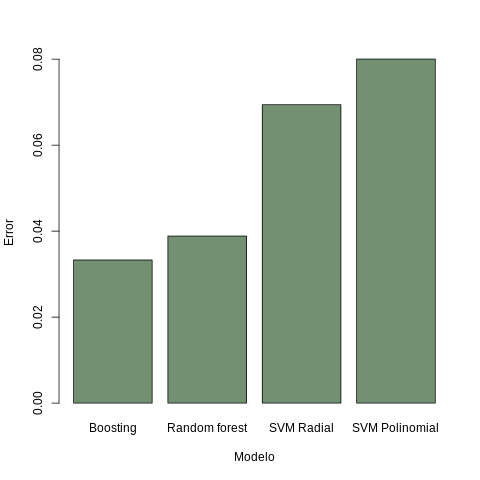

In [46]:
%%R
results <- data.frame("Modelo"=c("Boosting", "Random forest", "SVM Radial", "SVM Polinomial"),
                      "Error"=c(0.03328612, 0.03886686,  0.0694051, 0.08002833))

barplot(height=results$Error, names.arg=results$Modelo, xlab="Modelo", ylab="Error", col = "#739072")

Conclusiones:
- Hay que hacer la salvedad que debido a una limitación de la librería e1071 usada de R (ver https://stackoverflow.com/a/34246580/12309822), hubo varios casos donde el algoritmo alcanzó el límite interno de iteraciones impuesto por esta librería (como se puede ver en el output de la celda), y esto puede haber perjudicado la prueba real. A pesar de esto, se obtuvo un error del 8%, lo cual es bueno.
- SVM radial viene atrás con un error del 6%, el cual también es bueno, pero en comparativa a los otros métodos, los métodos de kernel fueron los que peor se comportaron.
- Tanto en boosting como en RF tenemos errores alrededor del 3%, lo cual es muy bueno. Hay que tener en cuenta que RF obtuvo algo muy similar y es un algoritmo mucho menos complejo que boosting.